# Gravitational astrophysics: resonances among the Saturnian satellites

## 1. Introduction

In [34]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

sim = rebound.Simulation()
sim.units = ('AU', 'days', 'Msun')

# We can add Jupiter and four of its moons by name, since REBOUND is linked to the HORIZONS database.
labels = ["699","Mimas","Tethys","Titan"]
sim.add(labels)

Searching NASA Horizons for '699'... 
Found: Saturn (699) 
Searching NASA Horizons for 'Mimas'... 
Found: Mimas (601) 
Searching NASA Horizons for 'Tethys'... 
Found: Tethys (603) 
Searching NASA Horizons for 'Titan'... 
Found: Titan (606) (chosen from query 'Titan')


In [35]:
os = sim.orbits()
print("n_i (in rad/days) = %6.3f, %6.3f, %6.3f" % (os[0].n,os[1].n,os[2].n))
print("P_i (in days)     = %6.3f, %6.3f, %6.3f" % (os[0].P,os[1].P,os[2].P))

n_i (in rad/days) =  6.631,  3.321,  0.394
P_i (in days)     =  0.947,  1.892, 15.948


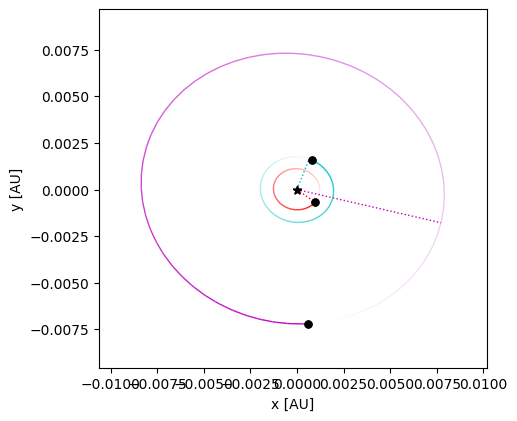

In [36]:
sim.move_to_com()
op = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True)

In [37]:
sim.integrator = "whfast"
sim.dt = 0.05 * os[0].P  # 5% of Io's period
Nout = 100000            # number of points to display
tmax = 80*365.25         # let the simulation run for 80 years
Nmoons = 3

In [ ]:
x = np.zeros((Nmoons,Nout))
ecc = np.zeros((Nmoons,Nout))
longitude = np.zeros((Nmoons,Nout))
Omega = np.zeros((Nmoons,Nout))
n = np.zeros((Nmoons,Nout))

times = np.linspace(0.,tmax,Nout)
ps = sim.particles

def ForceJ2(reb_sim):
    J2 = 1.629e-2
    for sat in range(Nmoons):
        prx = ps[sat].x
        pry = ps[sat].y
        prz = ps[sat].z
        pr2 = prx*prx + pry*pry + prz*prz
        fac = -3*6.67428e-11*J2*5.683e26/(2e30)*(58232/(149597870.7))**2/2/pr2**(3.5)

        pax = fac*prx*(prx*prx + pry*pry - 4*prz*prz)
        pay = fac*pry*(prx*prx + pry*pry - 4*prz*prz)
        pay = fac*prz*(3*(prx*prx + pry*pry) - 2*prz*prz)

        
sim.additional_forces = ForceJ2

for i,time in enumerate(times):
    sim.integrate(time)
    # note we use integrate() with the default exact_finish_time=1, which changes the timestep near 
    # the outputs to match the output times we want.  This is what we want for a Fourier spectrum, 
    # but technically breaks WHFast's symplectic nature.  Not a big deal here.
    os = sim.orbits()
    for j in range(Nmoons):
        x[j][i] = ps[j+1].x 
        ecc[j][i] = os[j].e
        longitude[j][i] = os[j].l
        Omega[j][i] = os[j].Omega
        n[j][i] = os[j].n

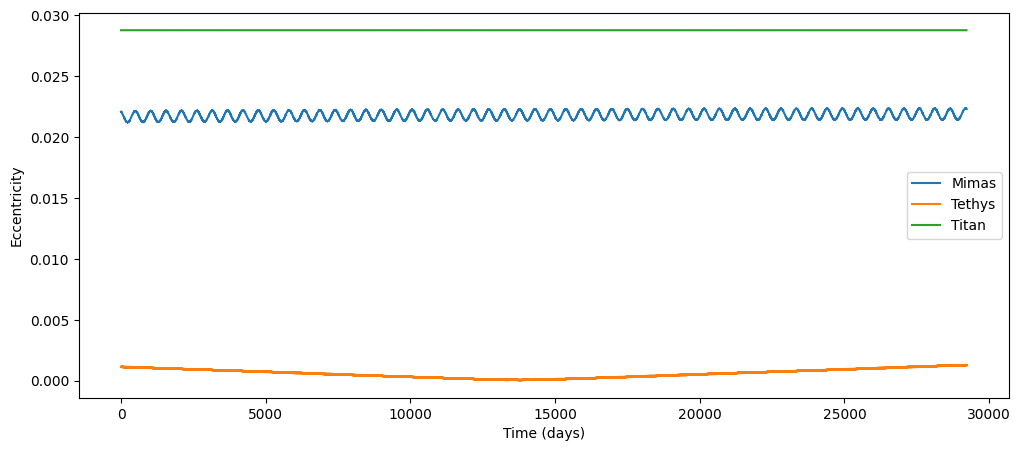

In [39]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,ecc[0],label=labels[1])
plt.plot(times,ecc[1],label=labels[2])
plt.plot(times,ecc[2],label=labels[3])
# plt.plot(times,ecc[3],label=labels[4])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Eccentricity")
plt.legend();

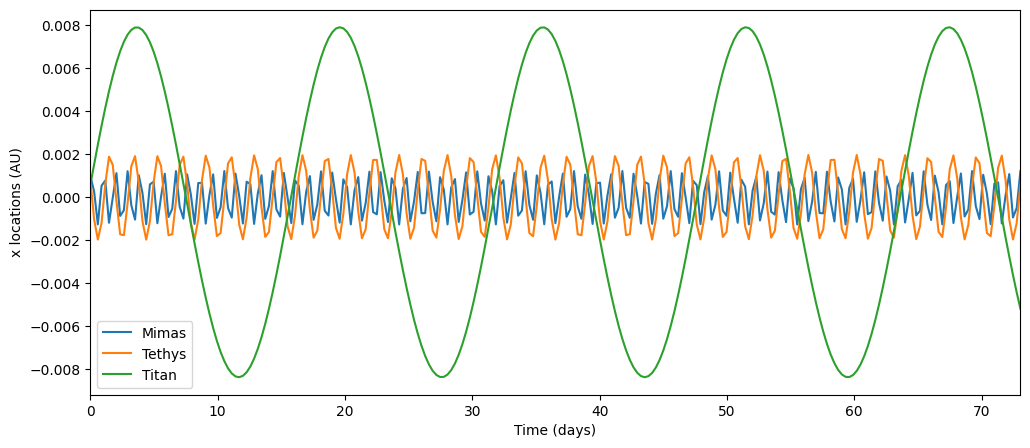

In [40]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,x[0],label=labels[1])
plt.plot(times,x[1],label=labels[2])
plt.plot(times,x[2],label=labels[3])
# plt.plot(times,x[3],label=labels[4])
ax.set_xlim(0,0.2*365.25)
ax.set_xlabel("Time (days)")
ax.set_ylabel("x locations (AU)")
ax.tick_params()
plt.legend();

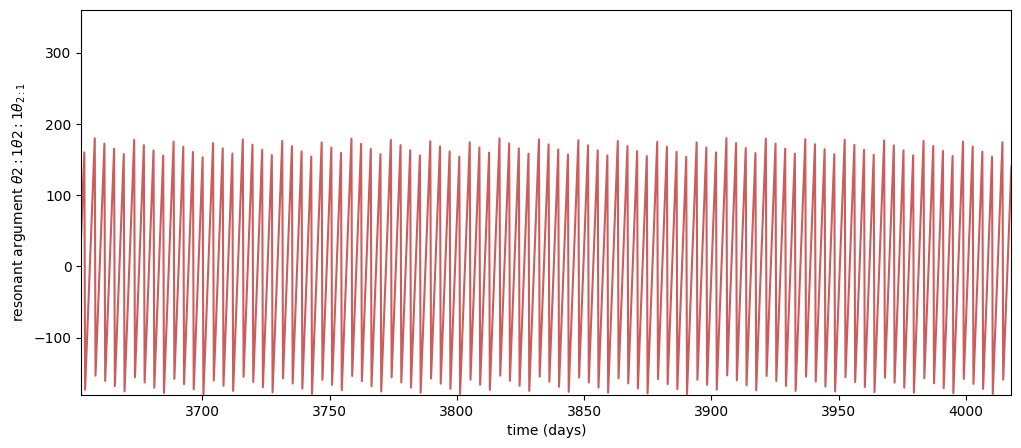

In [41]:
def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

def min180To180(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

# We can calculate theta, the resonant argument of the 1:2 Io-Europa orbital resonance,
# which oscillates about 0 degrees:
theta = [min180To180(2.*longitude[1][i] - 4.*longitude[0][i] + Omega[0][i] + Omega[1][i]) for i in range(Nout)]

# # There is also a secular resonance argument, corresponding to the difference in the longitude of perihelions:
# # This angle oscillates around 180 degs, with a longer period component.
# theta_sec = [zeroTo360(-varpi[1][i] + varpi[0][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,theta, color="indianred")  
# ax.plot(times,theta_sec, color="royalblue") # secular resonance argument
ax.set_xlim([0,20.*365.25])
ax.set_xlim([10*365.25,11*365.25])
ax.set_ylim([-180,360.])
ax.set_xlabel("time (days)")
ax.set_ylabel(r"resonant argument $θ2:1θ2:1\theta_{2:1}$")
ax.plot([0,100],[180,180],'k--')
ax.plot([0,100],[0,0],'k--')

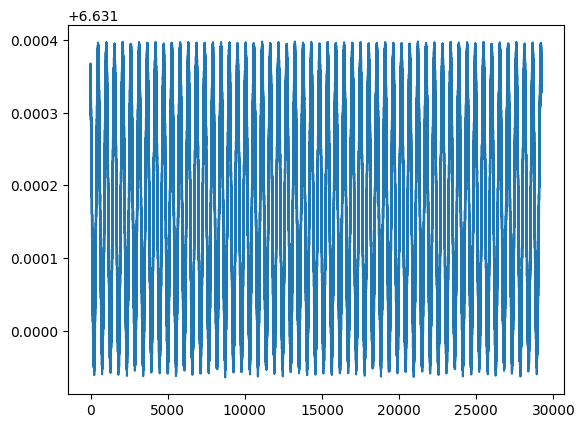

In [44]:
plt.plot(times,n[0])
# plt.plot(times,n[1])
plt.show()

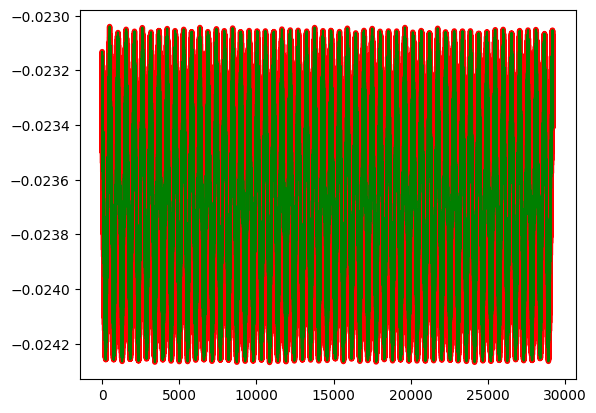

<Phi_dot> = -0.023700101885556615
<Phi_dot_alamain> = -0.023700105845636026


In [65]:
theta_prime = []
theta_prime.append((Omega[0][1:]-Omega[0][:-1])/(times[1]-times[0]))
theta_prime.append((Omega[1][1:]-Omega[1][:-1])/(times[1]-times[0]))
theta_prime = np.array(theta_prime)

# plt.plot(times[:-1], theta_prime[0])

dO = (np.gradient(Omega[0], times),np.gradient(Omega[1], times))

phidot = 2*n[0]-4*n[1]+dO[0]+dO[1]
phidot_alamain = 2*n[0][:-1]-4*n[1][:-1]+theta_prime[0]+theta_prime[1]

plt.plot(times,phidot, lw=4, color="red")
plt.plot(times[:-1],phidot_alamain, color="green")
plt.show()
print(f"<Phi_dot> = {np.mean(phidot)}")
print(f"<Phi_dot_alamain> = {np.mean(phidot_alamain)}")